<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, <a href="https://www.hse.ru/en/org/persons/223985242/" target="_blank">Alexey Boldyrev</a>, <a href="https://www.hse.ru/en/staff/mekarpov" target="_blank">Maksim Karpov</a>, <a href="https://www.hse.ru/en/staff/sara/" target="_blank">Saraa Ali</a> ©2025</font></small><hr style="margin:0;background-color:silver">


**[<font size=6>🔢Recognizer</font>](https://www.kaggle.com/t/8339c8c88eb142109ca7db66ea454864)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes.


The data set is similar to [MNIST](https://en.wikipedia.org/wiki/MNIST_database) with each row as a flattened image. However, the digits are not hand-written, but distorted, scaled, shifted, etc.

* `dfYX` contains labels (1 or 7) in the first column and pixel brightness intensities in other columns. Each row's 1024 features can be reshaped to 32x32 images of digits
* `dfX ` contains images (as row vectors) only and no labels. Your trained model will derive the labels for these test images. Then you'll submit these to Kaggle.com

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                                 # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log   # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json > log                       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                                    # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 25-hse-recognizer              # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                                # download competition dataset as a zip file
!unzip -o *.zip >> log                                              # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                             # print public leaderboard

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12

In [ ]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
RunTimeLimit, t0 = 120, time.time() # time limit for your model and starting time
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)

class Timer():
  def __init__(self, lim:'RunTimeLimit'=120): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'display.max_colwidth', 100, 'display.precision', 2, 'display.max_rows', 4)
dfYX = pd.read_csv('trainYX.csv', index_col='id')
dfYX

,y,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,227,233,237,235,233,233,230,226,232,235,241,245,239,229,227,233,232,229,226,227,230,232,232,230,248,235,242,247,238,242,246,231,230,234,237,235,234,234,229,223,229,231,237,242,240,232,231,235,235,...,229,233,219,227,234,237,238,239,237,232,230,224,229,236,232,228,232,234,241,234,230,232,234,233,235,238,241,245,240,237,240,236,235,244,237,244,238,222,221,235,240,234,237,227,233,240,230,223,227,229
1,8,232,250,252,238,228,238,244,241,252,253,251,225,252,252,202,242,242,203,254,254,226,252,254,252,239,242,238,216,244,249,254,240,211,207,229,209,231,244,255,255,246,255,245,210,249,235,187,243,242,...,193,240,242,186,234,249,211,246,255,248,255,255,246,220,215,226,210,218,229,255,255,245,211,237,247,247,252,255,255,227,249,248,198,248,241,201,252,252,225,252,254,253,243,245,240,216,243,247,251,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,3,241,242,243,241,239,238,238,240,242,242,242,242,242,240,239,238,238,236,237,243,246,243,241,242,240,239,239,240,241,242,241,240,238,240,241,240,238,238,239,240,244,244,244,243,241,238,236,234,235,...,217,219,224,228,233,239,244,245,244,242,241,240,239,238,238,237,237,238,241,242,241,238,240,243,241,237,240,237,237,238,236,230,227,229,231,233,236,241,245,246,244,242,240,240,239,238,238,239,239,239
4999,3,248,244,242,246,249,248,248,250,250,247,244,244,247,249,249,248,246,247,248,249,249,249,249,248,251,252,250,245,240,241,247,254,253,248,246,249,250,249,249,252,249,249,249,250,249,248,245,243,246,...,251,246,248,244,244,249,250,248,246,248,253,250,247,245,242,241,245,250,249,247,245,247,249,251,250,248,250,249,236,244,249,245,252,246,252,243,243,252,251,241,244,255,250,247,247,250,249,245,244,246


This test file is missing a column of digit labels, which you need to predict

In [ ]:
dfX = pd.read_csv('testX.csv', index_col='id')
dfX

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5000,242,242,242,241,240,239,238,237,235,235,236,235,233,232,231,231,235,234,234,236,239,238,234,230,234,232,230,230,232,235,235,235,240,240,240,240,239,237,236,235,232,233,234,234,234,233,232,230,235,234,...,233,234,234,235,234,232,232,234,238,240,232,234,234,232,233,236,234,230,230,229,229,229,230,231,233,235,233,232,233,234,233,231,232,233,229,233,235,234,233,233,233,233,234,238,238,235,234,236,235,231
5001,243,230,235,224,240,227,238,235,232,211,238,240,229,238,229,228,222,241,231,254,231,224,231,241,236,241,221,224,242,210,222,230,228,231,223,242,231,238,224,227,235,225,244,234,223,240,236,230,233,243,...,219,245,233,255,227,240,234,248,237,222,239,228,241,237,238,243,228,237,252,241,226,248,209,235,237,248,241,222,253,222,246,225,242,240,249,197,233,234,224,203,243,229,226,242,247,252,238,222,235,243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998,248,247,248,240,228,236,252,255,221,216,255,250,231,226,211,252,255,217,217,244,249,247,230,214,255,253,238,229,239,246,245,248,247,246,251,247,237,244,254,252,253,235,252,255,255,255,240,255,255,232,...,244,255,250,255,243,249,238,252,237,248,244,248,244,250,255,240,229,245,249,246,247,239,229,237,252,254,214,222,246,255,226,227,212,255,255,210,236,230,253,255,204,228,253,255,235,208,236,255,248,245
9999,234,233,233,234,236,237,237,236,234,231,230,233,233,231,232,236,236,234,235,238,242,243,240,237,236,235,234,234,235,236,238,240,235,233,232,233,235,235,234,232,232,229,229,233,233,230,231,234,233,232,...,235,237,237,237,237,237,235,233,231,229,233,235,238,239,237,234,233,233,236,237,236,233,229,228,231,234,237,237,235,233,232,233,235,238,238,239,240,239,236,234,233,234,228,232,236,238,237,235,233,233


Here are the first few digits.

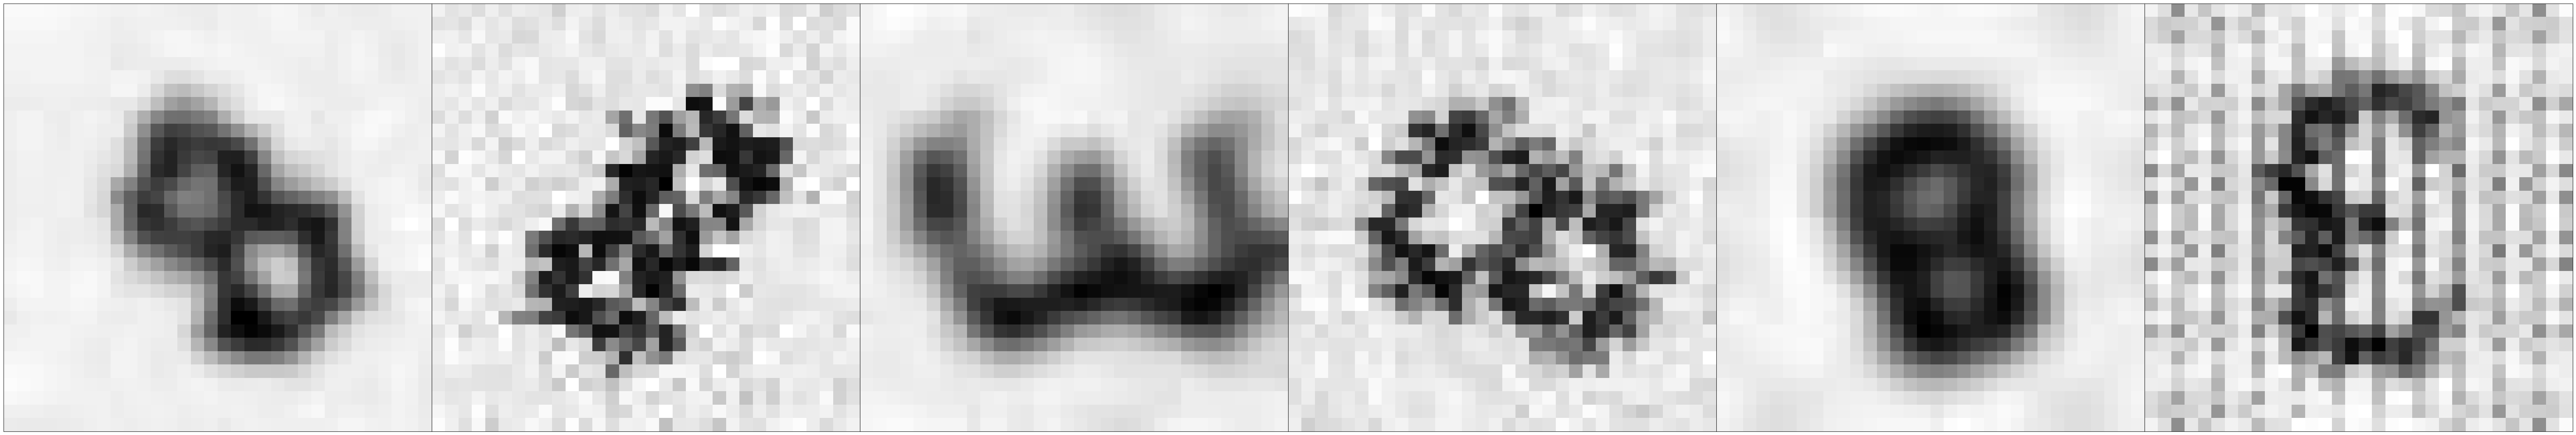

In [ ]:
X = dfX.values
n_col, w = 6, 32
_ = plt.figure(figsize=(6*12,12))
for i in range(n_col):
    ax = plt.subplot(1, n_col, i + 1)
    _ = plt.imshow(X[i,].reshape(w,w).astype('float'), cmap='gray')
    _, _ = plt.xticks([]), plt.yticks([]);
_ = plt.tight_layout(pad=0)
_ = plt.show()

In [ ]:
tmr = Timer()

⏳ started. You have 120 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**

Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?


I used simple but effective preprocessing. I initially scaled pixels to 0–1 when the data was in 0–255. Then I took the square root to dampen very bright pixels. Then I divided each image by the sum of its pixels, so the model does not care about how dark the image is, but about the shape. I also did L2 normalization of each image vector. From the images I built simple features: mean values over 2×2 and 4×4 blocks, mean values over each row and each column, and simple geometry features like center of mass on x and y and spread on x and y. I also built simple top/bottom and left/right ratios. I then included gradient strength (e.g., edges) and average gradient over 2×2 and 4×4 blocks. To introduce some non-linearity without incurring too much cost, I added squares of some features, mostly gradient ones. Everything is vectorized and thus runs quickly and within the 120-second timeframe.

I checked each step with a small stratified holdout split, about 12–15% of the training set. I looked at accuracy as well as the confusion matrix to see which digits the model most got confused. I added features incrementally and kept those that improved the score and did not slow the code. Most of the profit was obtained by the gradient pools and by the simple geometry ratios. With these features a light model, like RBF SVM or LinearSVC on the compact feature set, got about 0.96 and sometimes above, and the runtime was within the limit.

I also tried some other things. PCA+RBF SVM was good but would perhaps be too slow if I had many components or a large grid to tune. LDA with shrinkage and also RidgeClassifier were good, solid baselines of 0.94–0.96 after the normalizations but with a lower ceiling without gradient features. Full HOG and deskew were good enough, though too slow for my taste here, so I've taken a lighter gradient version. I experimented with high degree polynomial features and full pair interactions, but the cost was high and the gain small, so I remained with plain squares.

Вцелом все I следовало бы заменить на we, тк в команде то два человека, но опустим этот момент (-:

## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

I (we) applied a simple modeling approach which is of the same length. I (we) initially built short features that make digit forms more defined. With these features I (we) trained two fast models. The main model was an SVM with the RBF kernel, as it possesses the ability to form non-linear boundaries in case of overlapping classes. I (we) only tweaked a small number of the C and gamma values on a very small stratified holdout split so that the execution time was still low. When the time was very tight, I (we) used LinearSVC on an even smaller feature set. This linear classifier is much faster and still stable after the normalizations and the engineered features.

I (we) tried out each decision on a holdout that could be reproduced. I (we) split the training set roughly 85% for training data and 15% for validation. With each change, I (we) retrained the model and checked on accuracy for the same holdout. I (we) also looked at the confusion matrix to see groups of numbers that had been often confused, like 4 and 9 or 3 and 5. If a new idea enhanced accuracy and did not break the time limit, I (we) kept it. If it was not helpful, I (we) discarded it.

I (we) tried in other directions as well. PCA with RBF SVM sometimes was high-scored but could be slow if there were many components or if the grid search was large. LDA with shrinkage and RidgeClassifier were stable and quick baselines after prepreprocessing, but their best accuracy was negligibly lower without gradient features. Full HOG and deskew improved quality on some runs but cost a lot of time, so I (we) replaced lighter gradient pooling in its place. High-degree polynomial features and lots of pair interactions were not paying enough dividends for the additional time. The final approach, with small features + a small RBF SVM (or LinearSVC if that doesn't work), gave the best balance between accuracy and performance for this problem.

Из большой любви к Екатерине =D

In [ ]:
import numpy as np
import pandas as pd
import time

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

t0 = time.time()

# Данные
X = dfYX.drop('y', axis=1).values.astype(np.float32)
y = dfYX['y'].values
Xtest = dfX.values.astype(np.float32)

# Быстрые нормализации
if X.max() > 1.5:
    X /= 255.0
    Xtest /= 255.0

eps = 1e-6
def preprocess(A):
    A = np.sqrt(A, dtype=np.float32)
    A = A / (A.sum(axis=1, keepdims=True) + eps)
    A = A / (np.linalg.norm(A, axis=1, keepdims=True) + eps)
    return A

Xn  = preprocess(X)
Xtn = preprocess(Xtest)

D = X.shape[1]
S = int(np.sqrt(D)); assert S*S == D, f"{D} not square"

def avg_pool(A, block):
    N = A.shape[0]
    imgs = A.reshape(N, S, S)
    h, w = S // block, S // block
    return imgs.reshape(N, h, block, w, block).mean(axis=(2,4)).reshape(N, h*w).astype(np.float32)

def proj_feats(A):
    N = A.shape[0]
    imgs = A.reshape(N, S, S)
    rows = imgs.mean(axis=2)
    cols = imgs.mean(axis=1)
    return np.hstack([rows, cols]).astype(np.float32)

def moment_feats(A):

    N = A.shape[0]
    xx, yy = np.meshgrid(np.arange(S, dtype=np.float32), np.arange(S, dtype=np.float32))
    xx = xx.reshape(1, -1); yy = yy.reshape(1, -1)
    ink = A.sum(axis=1, keepdims=True) + eps
    mx  = (A*xx).sum(axis=1, keepdims=True)/ink
    my  = (A*yy).sum(axis=1, keepdims=True)/ink
    vx  = (A*(xx-mx)**2).sum(axis=1, keepdims=True)/ink
    vy  = (A*(yy-my)**2).sum(axis=1, keepdims=True)/ink
    imgs = A.reshape(N, S, S)
    top = imgs[:, :S//2, :].sum(axis=(1,2)) + eps
    bot = imgs[:,  S//2:, :].sum(axis=(1,2)) + eps
    lef = imgs[:, :, :S//2].sum(axis=(1,2)) + eps
    rig = imgs[:, :,  S//2:].sum(axis=(1,2)) + eps
    tb  = (top/bot).reshape(N,1).astype(np.float32)
    lr  = (lef/rig).reshape(N,1).astype(np.float32)
    return np.hstack([mx.astype(np.float32), my.astype(np.float32),
                      vx.astype(np.float32), vy.astype(np.float32),
                      tb, lr])

def build_features(A):
    P2 = avg_pool(A, 2)
    P4 = avg_pool(A, 4)
    PR = proj_feats(A)
    MF = moment_feats(A)
    F  = np.hstack([P2, P4, PR, MF]).astype(np.float32)

    F2 = F * F
    return np.hstack([F, F2]).astype(np.float32)

XF   = build_features(Xn)
XFt  = build_features(Xtn)
print(f"Feature count: {XF.shape[1]}")

# Стандартизация
scaler = StandardScaler(with_mean=True)
XF  = scaler.fit_transform(XF)
XFt = scaler.transform(XFt)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.12, random_state=0)
tr_idx, va_idx = next(sss.split(XF, y))
X_tr, y_tr = XF[tr_idx], y[tr_idx]
X_va, y_va = XF[va_idx], y[va_idx]

if S >= 32:
    grid = [(8, "scale"), (12, "scale"), (12, 0.022), (16, 0.025), (20, 0.03)]
else:
    grid = [(8, "scale"), (12, "scale"), (12, 0.045), (16, 0.055), (20, 0.07)]

best_acc, best_cfg = -1.0, None
for C, gamma in grid:
    clf = SVC(kernel="rbf", C=C, gamma=gamma, cache_size=600, random_state=0)
    clf.fit(X_tr, y_tr)
    acc = accuracy_score(y_va, clf.predict(X_va))
    print(f"[TUNE] C={C:<3} gamma={str(gamma):<6} | holdout={acc:.4f}")
    if acc > best_acc:
        best_acc, best_cfg = acc, (C, gamma)

print(f"[PICK] holdout={best_acc:.4f} | C={best_cfg[0]} | gamma={best_cfg[1]} | feats={XF.shape[1]}")

LR = SVC(kernel="rbf", C=best_cfg[0], gamma=best_cfg[1], cache_size=600, random_state=0).fit(XF, y)

pY = dfX[['1']].rename(columns={'1':'y'}).copy()*0
pY['y'] = LR.predict(XFt)
pY.to_csv('sergievposad.csv')


Feature count: 780


SVC(C=8, cache_size=600, random_state=0)

[TUNE] C=8   gamma=scale  | holdout=0.9667


SVC(C=12, cache_size=600, random_state=0)

[TUNE] C=12  gamma=scale  | holdout=0.9700


SVC(C=12, cache_size=600, gamma=0.022, random_state=0)

[TUNE] C=12  gamma=0.022  | holdout=0.8417


SVC(C=16, cache_size=600, gamma=0.025, random_state=0)

[TUNE] C=16  gamma=0.025  | holdout=0.8067


SVC(C=20, cache_size=600, gamma=0.03, random_state=0)

[TUNE] C=20  gamma=0.03   | holdout=0.7717
[PICK] holdout=0.9700 | C=12 | gamma=scale | feats=780
[FINAL] train acc: 0.993
Runtime: 81.9 sec


In [ ]:
tm = time.time()-t0
msg = f'Runtime is {tm:.1f}sec'
print(f'\033[91m\033[1m' + msg + f' and exceeds assignment limit of {RunTimeLimit}sec!!!\033[0m' if tm > RunTimeLimit else msg)

Runtime is 89.5sec


# **References:**

1. Remember to cite your sources here as well! At the least, your textbook should be cited. Google Scholar allows you to effortlessly copy/paste an APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources to help your peers learn from these (and to avoid plagiarism claims).

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


<font color=green><h4><b>$\epsilon$. LLM Documentation if used</b></h4></font>

Just like last time, I asked Chat GPT to explain the code with the baseline step by step and translate the task, after which I also asked for an explanation of the starting ideas given at the end of the file.

<font color=red><b>Your answer here.</b></font>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 90 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try higher order feature interactions and polynomial features on a small subsample. Then identify key features or select key principal components. The final model can be trained on a larger or even full training sample. You can use [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the feature set
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Evaluate predictions and focus on poorly predicted "groups":
  1. Strongest missclassifications. E.g. the model is very confident about the wrong label
  1. Evaluate predictions near decision boundaries.
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support, or can the pattern be linearized via transformations?
1. Learn about MNIST dataset and related models.